In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

import sys
import matplotlib.patches as mpatches

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

def eval (out, model, label):
    probs = model.activate(out)
    unc = model.aleatoric(out).cpu()
    pmax = probs.argmax(dim=1)
    lmax = label.argmax(dim=1)
    mis = pmax.cpu() != lmax.cpu()

    agree = mis.bool() == (unc > .5)

    return agree.float().mean().item()


In [15]:
from datasets.lyft import *
from datasets.nuscenes import *
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
level5data, dataroot = get_lyft("trainval", "../../data/lyft")
nusc_data = NuScenesDataset(level5data, True, pos_class="vehicle", ind=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 14.9 seconds.
Reverse indexing ...
Done reverse indexing in 3.9 seconds.
16506


In [35]:
images, intrinsics, extrinsics, labels, oods = nusc_data[0]

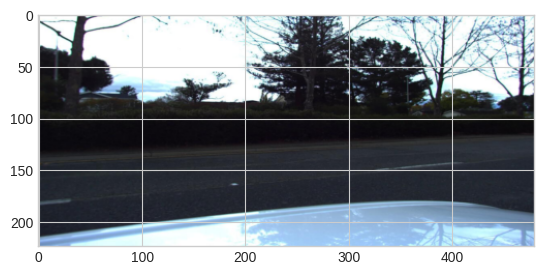

In [18]:
plt.imshow(images[0].permute(1, 2, 0))

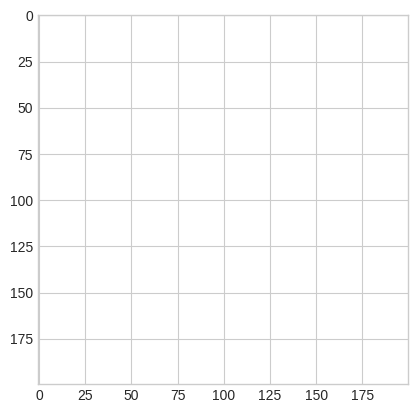

In [22]:
plt.imshow(labels[0])

In [ ]:
records = [(level5data.get('sample', record['first_sample_token'])['timestamp'], record) for record in
        level5data.scene]

entries = []

for start_time, record in sorted(records):
    start_time = level5data.get('sample', record['first_sample_token'])['timestamp'] / 1000000

    token = record['token']
    name = record['name']
    date = datetime.utcfromtimestamp(start_time)
    host = "-".join(record['name'].split("-")[:2])
    first_sample_token = record["first_sample_token"]

    entries.append((host, name, date, token, first_sample_token))
            
df = pd.DataFrame(entries, columns=["host", "scene_name", "date", "scene_token", "first_sample_token"])

In [ ]:
samples = [samp for samp in level5data.scene]

In [ ]:
samples[0]['data']

In [ ]:
host_count_df = df.groupby("host")['scene_token'].count()
print(host_count_df)

In [ ]:
validation_hosts = ["host-a007", "host-a008", "host-a009"]

validation_df = df[df["host"].isin(validation_hosts)]
vi = validation_df.index
train_df = df[~df.index.isin(vi)]

In [ ]:
len(train_df)

In [ ]:
classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]


In [ ]:
sample_token = train_df.first_sample_token.values[0]
sample = level5data.get("sample", sample_token)

sample_lidar_token = sample["data"]["LIDAR_TOP"]
lidar_data = level5data.get("sample_data", sample_lidar_token)
lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)

ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
calibrated_sensor = level5data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])

# Homogeneous transformation matrix from car frame to world frame.
global_from_car = transform_matrix(ego_pose['translation'],
                                   Quaternion(ego_pose['rotation']), inverse=False)

# Homogeneous transformation matrix from sensor coordinate frame to ego car frame.
car_from_sensor = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation']),
                                    inverse=False)